In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [3]:
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

In [4]:

def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
    else:
        print("Specified model not available")
    return model

In [5]:
model_architecture = 'resnet'
model = model_picker(model_architecture)

94773248/94765736 [==============================] - 1s 0us/step


In [6]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [8]:
features = extract_features('/content/drive/MyDrive/ds/pizza_images/all_images/data/amatos-pizza-and-more-chicago_0.jpeg', model)
apart = extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', model)
print(len(features))
print(apart)

2048
[0.00178475 0.00101728 0.00843327 ... 0.00108938 0.00463534 0.03208936]


In [9]:
apart_fine = extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', model_finetuned)
pickle.dump(apart,open('/content/drive/My Drive/ds/pizza_images/autoencoder/features-resnet-apart.pickle', 'wb'))
print(len(apart_fine))
print(apart_fine)

1
[1.]


In [41]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list

In [ ]:
# path to the your datasets
root_dir = '/content/drive/MyDrive/ds/pizza_images/all_images/data/'
filenames = sorted(get_file_list(root_dir))

feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
batch_size = 64
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory('/content/drive/MyDrive/ds/pizza_images/all_images/',
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
feature_list = model.predict_generator(generator, num_epochs)
end_time = time.time()

Found 2023 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(num_images, -1)
filenames = [root_dir + '/' + s for s in generator.filenames]
print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  2023
Shape of feature_list =  (2023, 2048)
Time taken in sec =  353.40863704681396


In [ ]:
pickle.dump(generator.classes, open('/content/drive/My Drive/ds/pizza_images/autoencoder/OGresnet_classids.pickle',
                                    'wb'))
pickle.dump(filenames, open('/content/drive/My Drive/ds/pizza_images/autoencoder/OGfilenames_images.pickle', 'wb'))
pickle.dump(
    feature_list,
    open('/content/drive/My Drive/ds/pizza_images/autoencoder/OGfeatures-' + model_architecture + '.pickle', 'wb'))

In [ ]:
feature_list[0]

array([0.00599818, 0.01011654, 0.01637081, ..., 0.00585441, 0.01143654,
       0.02530114], dtype=float32)

In [15]:
batch_size = 64
TRAIN_SAMPLES = 200
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [10]:
from shutil import copy2

# Sample files used to train model drawn from all images
sample_size = 200
thin_pop = '/content/drive/MyDrive/ds/pizza_images/pizza_topics/thin/'
thick_pop = '/content/drive/MyDrive/ds/pizza_images/pizza_topics/thick/'
thin_sample = '/content/drive/MyDrive/ds/pizza_images/resnet_training/thin/'
thick_sample = '/content/drive/MyDrive/ds/pizza_images/resnet_training/thick/'

total_thin_count = len([name for name in os.listdir(thin_pop)])
total_thick_count = len([name for name in os.listdir(thick_pop)])
thin_image_names = os.listdir(thin_pop)
thick_image_names = os.listdir(thick_pop)

# thin_sample_indices = np.random.randint(0, total_thin_count, size=sample_size)
# thick_sample_indices = np.random.randint(0, total_thick_count, size=sample_size)
# thin_sample_indices = thin_sample_indices[:int(sample_size)]
# thick_sample_indices = thick_sample_indices[:int(sample_size)]

# for index in thin_sample_indices:
#     copy2(thin_pop +  thin_image_names[index], thin_sample + thin_image_names[index])
# for index in thick_sample_indices:
#     copy2(thick_pop + thick_image_names[index], thick_sample + thick_image_names[index])

In [61]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=70,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [62]:
batch_size=32
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/ds/pizza_images/resnet_training/',
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 332 images belonging to 2 classes.


In [64]:
def model_maker():
    base_model = ResNet50(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu', name='encoded_layer')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)
    # Can I just change outputs to be another layer?

In [65]:
model_finetuned2 = model_maker()
model_finetuned2.compile(loss='mse',
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['acc'])
history = model_finetuned2.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
    epochs=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
7/7 [==============================] - 43s 6s/step - loss: 0.3616 - acc: 0.5042
Epoch 2/20
7/7 [==============================] - 41s 6s/step - loss: 0.2821 - acc: 0.6067
Epoch 3/20
7/7 [==============================] - 36s 5s/step - loss: 0.1849 - acc: 0.7584
Epoch 4/20
7/7 [==============================] - 36s 5s/step - loss: 0.2146 - acc: 0.7247
Epoch 5/20
7/7 [==============================] - 41s 6s/step - loss: 0.2275 - acc: 0.7109
Epoch 6/20
7/7 [==============================] - 41s 6s/step - loss: 0.1757 - acc: 0.7914
Epoch 7/20
7/7 [==============================] - 37s 6s/step - loss: 0.1451 - acc: 0.7967
Epoch 8/20
7/7 [==============================] - 38s 5s/step - loss: 0.1772 - acc: 0.7609
Epoch 9/20
7/7 [==============================] - 39s 5s/step - loss: 0.1521 - acc: 0.8021
Epoch 10/20
7/7 [==============================] - 42s 6s/step - loss: 0.1484 - acc: 0.8001
Epoch 11/20
7/7 [==============================] - 38s 5s/step - loss: 0.1392 - acc: 0.79

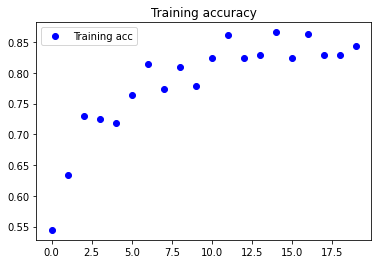

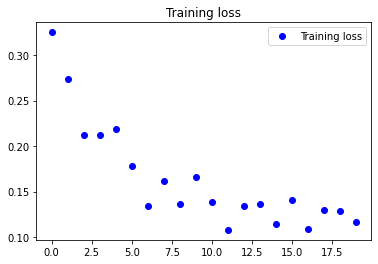

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot accuracy and loss for training and validation sets
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [69]:
# model_finetuned.save('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet.h5')
# model_finetuned.save('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_10.h5')
# model_finetuned.save('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_bs32.h5')
model_finetuned2.save('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_shear.h5')

In [21]:
model_finetuned1 =  tensorflow.keras.models.load_model('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet1.h5')
model_finetuned2 =  tensorflow.keras.models.load_model('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_10.h5')
model_finetuned3 =  tensorflow.keras.models.load_model('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_bs32.h5')
model_finetuned4 =  tensorflow.keras.models.load_model('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_shear.h5')

In [22]:
apart_1 = extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', model_finetuned1)
apart_2 = extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', model_finetuned2)
apart_3 = extract_features('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', model_finetuned3)
print('Length of first feature set is:',len(apart_1))
print('Apart would have the vector:',apart_1)
print('Length of second feature set is:',len(apart_2))
print('Apart would have the vector:',apart_2)
print('Length of third feature set is:',len(apart_3))
print('Apart would have the vector:',apart_3)

Length of first feature set is: 1
Apart would have the vector: [1.]
Length of second feature set is: 2
Apart would have the vector: [0.68838465 0.7253459 ]
Length of third feature set is: 2
Apart would have the vector: [0.76041836 0.6494335 ]


In [25]:
def model_maker2():
    base_model = ResNet50(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model= Dense(64, activation='relu', name='encoded_layer')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [26]:
model_finetuned = model_maker2()
model_finetuned.compile(loss='mse',
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_finetuned.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
    epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
7/7 [==============================] - 45s 6s/step - loss: 0.3700 - acc: 0.4993
Epoch 2/10
7/7 [==============================] - 37s 6s/step - loss: 0.2266 - acc: 0.7116
Epoch 3/10
7/7 [==============================] - 40s 6s/step - loss: 0.2056 - acc: 0.7218
Epoch 4/10
7/7 [==============================] - 38s 5s/step - loss: 0.1820 - acc: 0.7384
Epoch 5/10
7/7 [==============================] - 40s 6s/step - loss: 0.2147 - acc: 0.6981
Epoch 6/10
7/7 [==============================] - 41s 5s/step - loss: 0.1632 - acc: 0.7571
Epoch 7/10
7/7 [==============================] - 41s 6s/step - loss: 0.1672 - acc: 0.7803
Epoch 8/10
7/7 [==============================] - 37s 5s/step - loss: 0.1336 - acc: 0.8159
Epoch 9/10
7/7 [==============================] - 41s 6s/step - loss: 0.1562 - acc: 0.8011
Epoch 10/10
7/7 [==============================] - 36s 5s/step - loss: 0.1579 - acc: 0.8151


In [ ]:
model_finetuned_encoded.save('/content/drive/My Drive/ds/pizza_images/autoencoder/finetuned_resnet_thickthin_encoded.h5')

In [70]:
feature_extractor2 = Model(inputs=model_finetuned2.input, outputs=model_finetuned2.get_layer('encoded_layer').output)

In [37]:
# Functions to convert images to 3D (image_dim, image_dim, 3) 
# or 4D (1, image_dim, image_dim, 3) tensors

image_dimension = 224

def image_to_3d_tensor(image_path):
    im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
    return im/255

def image_to_4d_tensor(image_path):
    im = image_to_3d_tensor(image_path)
    im = im.reshape(1, image_dimension, image_dimension, 3)
    return im

In [51]:
apart_new = feature_extractor(image_to_4d_tensor('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg'), model_finetuned)
print('Length of first feature set is:',len(apart_new[0]))
print('Apart would have the vector:',apart_new)
pickle.dump(apart_new,open('/content/drive/My Drive/ds/pizza_images/autoencoder/features_resnet_apart_new.pickle', 'wb'))

Length of first feature set is: 64
Apart would have the vector: tf.Tensor(
[[1.1191238  0.         0.4273147  0.         0.         1.0270787
  0.3987035  0.         0.2897739  0.         0.         0.
  0.         0.         0.         0.         1.5317378  0.09443825
  0.         0.00446777 0.         0.         0.30784902 0.
  0.         0.         0.         0.         1.8419851  0.
  0.447735   0.         0.41226494 0.         0.         0.
  0.         0.         0.         0.03716054 0.         0.
  0.22442544 0.         0.         0.         0.         0.
  1.7905525  0.         0.         0.         0.5338802  0.6811141
  0.         0.         0.         0.8679581  0.         0.
  1.1879715  0.         0.         0.        ]], shape=(1, 64), dtype=float32)


In [71]:
# path to the your datasets
yelp_dir = '/content/drive/MyDrive/ds/pizza_images/yelp_only/data/'
yelp_filenames = sorted(get_file_list(yelp_dir))

extracted_feature_list_yelp = []
for i in tqdm_notebook(range(len(yelp_filenames))):
    extracted_feature_list_yelp.append(feature_extractor2(image_to_4d_tensor(yelp_filenames[i]), model_finetuned2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [72]:
pickle.dump(extracted_feature_list_yelp,open('/content/drive/My Drive/ds/pizza_images/autoencoder/moreepochs_features_tensors-' + model_architecture + '.pickle', 'wb'))

In [57]:
for i, features in enumerate(extracted_feature_list_yelp):
    extracted_feature_list_yelp[i] = features / norm(features)

extracted_feature_list_yelp = extracted_feature_list_yelp.reshape(num_images, -1)
# print("Num images   = ", len(new_generator.classes))
print("Shape of feature_list = ", extracted_feature_list_yelp.shape)


AttributeError: ignored

In [44]:
batch_size = 32
new_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

new_generator = new_datagen.flow_from_directory('//content/drive/MyDrive/ds/pizza_images/yelp_only/',
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(new_generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list_yelp = []
# feature_list_yelp = feature_extractor(image_to_4d_tensor('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg'), model_finetuned)
feature_list_yelp = model_finetuned.predict_generator(new_generator, num_epochs)
end_time = time.time()

Found 1698 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [45]:
for i, features in enumerate(feature_list_yelp):
    feature_list_yelp[i] = features / norm(features)

feature_list_yelp = feature_list_yelp.reshape(num_images, -1)
print("Num images   = ", len(new_generator.classes))
print("Shape of feature_list = ", feature_list_yelp.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  1698
Shape of feature_list =  (1698, 2)
Time taken in sec =  258.47179317474365


In [54]:
yelp_filenames = ['/content/drive/MyDrive/ds/pizza_images/yelp_only/' + s for s in new_generator.filenames]
yelp_filenames[0]

'/content/drive/MyDrive/ds/pizza_images/yelp_only/data/als-pizza-chicago_0.jpeg'

In [60]:
pickle.dump(new_generator.classes, open('/content/drive/My Drive/ds/pizza_images/autoencoder/new_resnet_classids.pickle','wb'))
pickle.dump(yelp_filenames, open('/content/drive/My Drive/ds/pizza_images/autoencoder/new_filenames_images.pickle', 'wb'))
pickle.dump(feature_list_yelp,open('/content/drive/My Drive/ds/pizza_images/autoencoder/new_features-' + model_architecture + '.pickle', 'wb'))
pickle.dump(extracted_feature_list_yelp,open('/content/drive/My Drive/ds/pizza_images/autoencoder/new_features_tensors-' + model_architecture + '.pickle', 'wb'))

In [ ]:
# Corpus directory
corpus_image_directory = allimage_directory
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

In [ ]:
np.random.normal()

In [ ]:
feature_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
feature_generator = feature_datagen.flow_from_directory('/content/drive/MyDrive/ds/pizza_images/yelp_only/',
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 1698 images belonging to 1 classes.


In [ ]:
start_time = time.time()
feature_list_finetuned = []

num_images = len(feature_generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list_finetuned = feature_extractor.predict_generator(feature_generator, num_epochs)
end_time = time.time()

for i, features_finetuned in enumerate(feature_list_finetuned):
    feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

feature_list_two = feature_list_finetuned.reshape(num_images, -1)

print("Num images   = ", len(feature_generator.classes))
print("Shape of feature_list = ", feature_list_two.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  1698
Shape of feature_list =  (1698, 2)
Time taken in sec =  309.4018552303314


In [ ]:
pickle.dump(feature_list_two, open('/content/drive/My Drive/ds/pizza_images/autoencoder/features-resnet-finetuned2.pickle', 'wb'))
feature_list_two[0]

array([0.9302449 , 0.36693925], dtype=float32)

In [ ]:
feature_list = pickle.load(open('/content/drive/My Drive/ds/pizza_images/autoencoder/features-resnet-finetuned2.pickle','rb'))

In [ ]:
model_finetuned.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 23,718,978
Trainable params: 131,266
Non-trainable params: 23,587,712
___________________________________________

In [ ]:
# Save feature extractor
feature_extractor = Model(inputs=model_finetuned.input, outputs=model_finetuned.get_layer('dense').output)
# feature_extractor
# apart = feature_extractor('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg')
# print(apart)

In [ ]:
feature_extractor.save('/content/drive/My Drive/ds/pizza_images/autoencoder/feature_extractor_finetuned2.h5')

1698

In [ ]:
layer_name = 'dense'
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model(data)

In [ ]:
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name,model):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    layer_name = 'dense'
    intermediate_layer_model = tensorflow.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    # 6. Run the model on our transformed image
    intermediate_output = intermediate_layer_model(t_img)
    # 8. Return the feature vector
    return my_embedding

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
get_vector('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg', model_finetuned)

AttributeError: ignored

In [ ]:
# Functions to convert images to 3D (image_dim, image_dim, 3) 
# or 4D (1, image_dim, image_dim, 3) tensors

image_dimension = 224

def image_to_3d_tensor(image_path):
    im = cv2.resize(cv2.imread(image_path), (image_dimension, image_dimension)).astype(np.float32)
    return im/255

def image_to_4d_tensor(image_path):
    im = image_to_3d_tensor(image_path)
    im = im.reshape(1, image_dimension, image_dimension, 3)
    return im

In [ ]:
# Corpus directory
corpus_image_directory = '/content/drive/MyDrive/ds/pizza_images/yelp_only/data/'
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

1698


In [ ]:
# Instantiate tensors array and list of filenames
corpus_tensors = np.zeros((1, image_dimension, image_dimension, 3))
corpus_tensors_list = []
corpus_filenames = []

In [ ]:
# image_to_3d_tensor(corpus_image_directory + os.listdir(corpus_image_directory)[0])

In [ ]:
# Create image tensors and filename list
for filename in os.listdir(corpus_image_directory):
    corpus_filenames.append(filename)
    try: 
        corpus_tensors_list.append(image_to_3d_tensor(corpus_image_directory + filename))
    except: 
        pass
    if len(corpus_tensors_list) % 50 == 0: print('Processed:', len(corpus_tensors_list)) 
corpus_tensors = np.array(corpus_tensors_list)

Processed: 50
Processed: 100
Processed: 150
Processed: 200
Processed: 250
Processed: 300
Processed: 350
Processed: 400
Processed: 450
Processed: 500
Processed: 550
Processed: 600
Processed: 650
Processed: 700
Processed: 750
Processed: 800
Processed: 850
Processed: 900
Processed: 950
Processed: 1000
Processed: 1050
Processed: 1100
Processed: 1150
Processed: 1200
Processed: 1250
Processed: 1300
Processed: 1350
Processed: 1400
Processed: 1450
Processed: 1500
Processed: 1550
Processed: 1600
Processed: 1650


In [ ]:
test_image_file = '/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg'
test_tensor = image_to_4d_tensor(test_image_file)
test_features = feature_extractor.predict(test_tensor,verbose=1)
len(test_features[0])
# print(test_features.shape[0])
# print(test_features.shape[1] * test_features.shape[2] * test_features.shape[3])

1/1 [==============================] - 0s 199ms/step


64

In [ ]:
corpus_image_directory = '/content/drive/MyDrive/ds/pizza_images/yelp_only/data/'
corpus_image_count = len([name for name in os.listdir(corpus_image_directory)])
print(corpus_image_count)

In [ ]:
from PIL import Image

In [ ]:
def compare_test_image(test_image_file, metric='cosine'):
    
    # Display original image
    print('Original image')
    im = Image.open(test_image_file)
    im.show()
    # display(Image(test_image_file, width = image_dimension, height = image_dimension))
    
    # Predict feature values for test image
    test_tensor = image_to_4d_tensor(test_image_file)
    test_features = feature_extractor.predict(test_tensor)
    
    # Use a vectorized function (spatial.distance.cdist) to calculate the distance between
    # the test image and each of the images in the corpus.
    # Images need to be converted to '2d' for use in distance.cdist.
    # First dimension is number of images (1 for test, corpus size for corpus).
    # Second dimension is width x height x number of color channels.
    test_features_2d = np.reshape(test_features, (test_features.shape[0], test_features.shape[1] * test_features.shape[2] * test_features.shape[3]))
    corpus_features_2d = np.reshape(corpus_features, (corpus_features.shape[0], corpus_features.shape[1] * corpus_features.shape[2] * corpus_features.shape[3]))
    
    # Run comparison
    distance_array = spatial.distance.cdist(test_features_2d, corpus_features_2d, metric=metric)

    # If #1 best match is indistinguishable from test image, skip 
    shift = 0
    if np.min(distance_array) < .001: shift = 1
        
    # Return top 5 id numbers using argsort
    top5ids = [corpus_filenames[index] for index in distance_array.argsort()[0][0+shift:5+shift].tolist()]
    top5list = []
    
    return top5ids

In [ ]:
# Execute comparison for test image.
top5 = compare_test_image('/content/drive/MyDrive/ds/pizza_images/autoencoder/test/veranda_test.jpg')

Original image


IndexError: ignored